# ZILLOW PROJECT
## Predicting the tax value of single family homes in the Los Angeles area

## Project Description

This Jupyter Notebook and presentation explore the Zillow dataset from the Codeup database. The data used relates to 2017 real estate transactions relating to single family homes in three California counties, and different aspects of the properties. An part aspect of the Zillow business model is to be able to publish accurate home values; I intend to build a machine learning model that makes predictions about the tax value of the homes in question.


## Project Goals

The ultimate goal of this project is to build a model that predicts the tax value of these homes with a higher accuracy than the baseline I have chosen. I will use Residual Mean Square Error as my metric for evaluation, and many models will be built using different features and hyperparameters to find the model of best fit.

The final deliverable will be the RMSE value resulting from my best model, contrasted with the baseline RMSE.

Additionally, a Jupyter Notebook and presentation with my main findings and conclusions will be a key deliverable; many .py files will exist as a back-up to the main Notebook (think "under-the-hood" coding that will facilitate the presentation).

## Executive Summary

Zillow needs to publish the most accurate home valuations possible to remain the relevant, reliable service that it is known to be.  This study has found certain aspects of homes in the vicinity of Los Angeles to have certain features that, when accurately recorded, help our model beat the baseline prediction. 

Further research will continue benefitting the model--even with just the data immediately available, it is my opinion that we can continue getting our predictions more accurate. As it stands, the model I am presenting in this notebook is beating the baseline model by over 11%.

In [1]:
# Cell to import key python libraries and functions, and my own modules, to be used in the notebook:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
from scipy import stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
# importing my personal wrangle module
import wrangle
import model
import viz

In [2]:
# Acquiring the data using the wrangle
zillow_sql_query = wrangle.get_zillow_data()
# I am working with a copy of the SQL query to be able to access it faster
zillow = zillow_sql_query.copy()

In [3]:
# Using my wrangle module to clean and prep the data. NaNs are dropped; so are outliers. 
# An 'age' column has been added
# The yearbuilt column was deleted
# No outliers were removed from year built, age, or fips; they were removed from all other features, 
# dropping their respective rowss
zillow = wrangle.clean_and_prep_data(zillow)

In [4]:
zillow.head()

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom
0,4.0,3.5,3100.0,1023282.0,Orange,23,885.714286
1,2.0,1.0,1465.0,464000.0,Ventura,54,1465.000000
2,3.0,2.0,1243.0,564778.0,Orange,59,621.500000
3,4.0,3.0,2376.0,145143.0,LA,51,792.000000
4,4.0,3.0,2962.0,773303.0,LA,71,987.333333


In [5]:
# my clean_and_prep function is cutting down the size here by 
# dropping NaNs and removing outliers--the majority of the rows dropped were outliers.
zillow.shape, zillow_sql_query.shape

((44864, 7), (52442, 7))

## Initial data exploration:

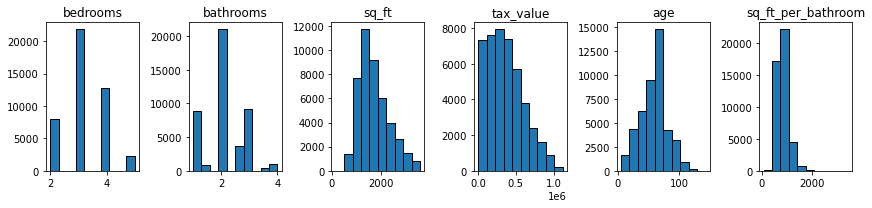

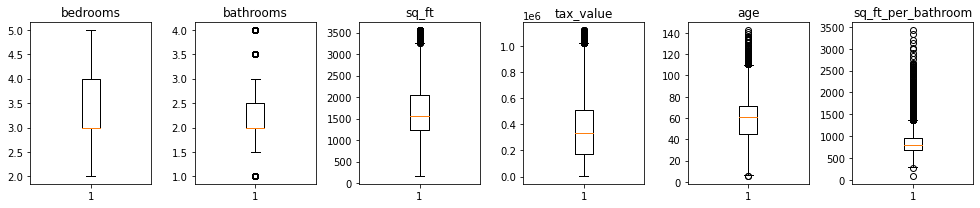

In [6]:
# Here, we create a for loop that makes a histogram for every column. This is the start of my univariate analysis
viz.histograms(zillow)

In [8]:
# Describe was displaying with scientific notation, so I rounded to 2 places.  
round(zillow.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
bedrooms,44864.0,3.21,0.79,2.0,3.0,3.0,4.0,5.0
bathrooms,44864.0,2.09,0.72,1.0,2.0,2.0,2.5,4.0
sq_ft,44864.0,1694.01,605.61,152.0,1238.0,1568.0,2050.0,3566.0
tax_value,44864.0,363580.89,233629.59,1000.0,171473.0,331368.0,511394.0,1122409.0
age,44864.0,58.98,21.62,5.0,45.0,61.0,71.0,143.0
sq_ft_per_bathroom,44864.0,840.16,227.00,76.0,683.0,803.0,955.0,3438.0


### I relied on an encoded version of the data set for some of my visual exploration, but much of the following exploration relies on the unencoded version.

In [9]:
# This cell utilizes a function in my wrangle.py to encode the fips (renamed 'county')
encoded = wrangle.encode_zillow(zillow)

# SPLITTING

In [10]:
# Wrangle.py has a function to split the data into train, validate and test sets
# Additionally, I have split further in X_ and y_ sets for train, validate and test respectively
train, validate, test,X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_zillow(encoded)

# SCALING
### I've done it in this order so I can explore different data sets as is appropriate

In [11]:
# Wrangly.py also has a function to scale my data
# I saved these to different variables so I could use the exact data set for different analyes
train_scaled, X_train_scaled, y_train_scaled, \
validate_scaled, X_validate_scaled, y_validate_scaled, \
test_scaled, X_test_scaled, y_test_scaled = wrangle.scale_zillow(train, validate, test)

# DATA EXPLORATION--BIVARIATE AND MULTIVARIATE

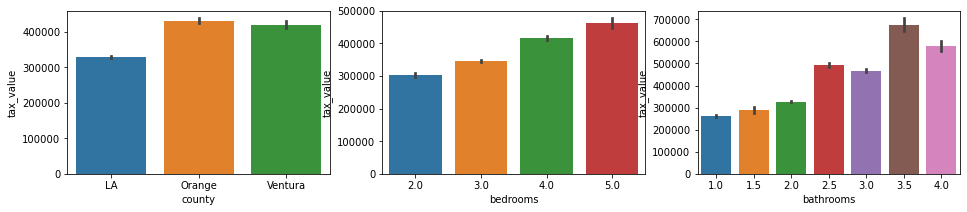

In [12]:
# A function from my viz.py file to create some bivariate barplots in seaborn
viz.three_histograms(train)

### Orange county has the highest-valued houses, on average, followed by Ventura

### More bathrooms raise the tax value; do half bathrooms have a larger effect?

<AxesSubplot:>

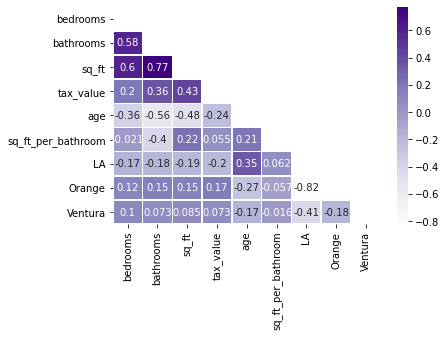

In [14]:
# This code is creating a variable holding the correlations of the different variable between each other
train_corr = train.corr()
# And here, we use the variable to draw up a seaborn heatmap for a better visual
sns.heatmap(train_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(train_corr))

### This heatmap is what inspired me to take a look at the square feet per bathroom, which you saw above as an added feature; I do statistical testing immediately below.

In [55]:
# Here, I use boolean masking to create variables holding only those houses with 2 bathrooms, for example, or 1 or 3
baths_2 = train[train.bathrooms == 2.00].sq_ft
baths_1 = train[train.bathrooms == 1.00].sq_ft
baths_3 = train[train.bathrooms == 3.00].sq_ft
baths_2_5 = train[train.bathrooms == 2.50].sq_ft
baths_4 = train[train.bathrooms == 4.00].sq_ft
baths_1_5 = train[train.bathrooms == 1.50].sq_ft
baths_3_5 = train[train.bathrooms == 3.50].sq_ft

Set Hypothesis
- 𝐻0 : Population means of sq_ft (by bathrooms) counts are equal
- 𝐻𝑎 : Population means of sq_ft (by bathrooms) are not all equal

In [56]:
# This cell runs an ANOVA test on the different 'bathroom categories'
# We are demonstrating statistically that the number of bathrooms correlates to the square footage
f, p = stats.f_oneway(baths_2, baths_1, baths_3, baths_2_5,baths_4,baths_1_5,baths_3_5)
f, p

(6818.1000019266785, 0.0)

In [57]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We reject H_O


### The ANOVA test shows that we can procede with the understanding that more square feet correlates with a higher number of bathrooms; I have also added a square feet per bathroom feature to the dataset in my wrangle.py for further exploration below.

## Research question number 1: 

Are bigger houses valued higher?

<AxesSubplot:title={'center':'There seems to be a positive correlation between square feet and tax_value'}, xlabel='sq_ft', ylabel='tax_value'>

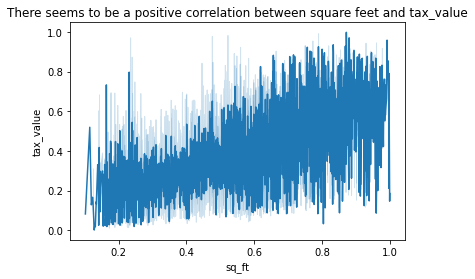

In [21]:
# This cell creates a seaborn lineplot--it's not the best plot for the data, per se,
# but creates a good visual to demonstrate the relationship
plt.title('There seems to be a positive correlation between square feet and tax_value')
sns.lineplot(x=train_scaled.sq_ft.sample(10_000), y=train_scaled.tax_value)#,markers=True)

### In the following cells, we will establish statistically the relationship:

Hypothesis testing: 

    H_o: Square feet and tax_value are not related
    H_a: Square feet and tax_value are related
    

In [22]:
# This cell runs a pearson-r correlation test on the square feet and tax value variables
alpha = 0.05

corr, p = stats.pearsonr(train.sq_ft, train.tax_value)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p

We reject the null hypothesis


(0.4335428740580575, 0.0)

### There is statistical evidence of a moderate correlation between the variables, and I will proceed with this understanding.

## Research question number 2: what are some of the other aspects of higher-tax value homes:

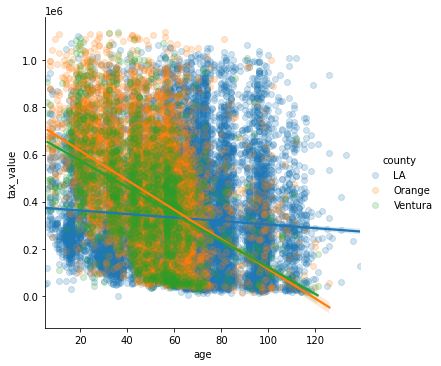

In [23]:
# I created a seaborn lmplot here to show the relationship between age and tax value
# The chart is drawn using 'county' as the hue
sns.lmplot(x='age', y='tax_value', data=train, scatter_kws={'alpha':.2},hue='county')#line_kws={'color': 'red'},

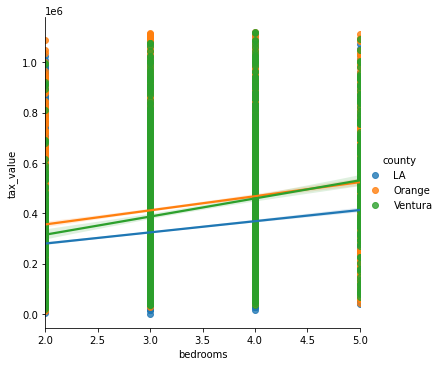

In [24]:
# A seaborn lmplot, mostly to show the regression line between counties.
sns.lmplot(x='bedrooms', y='tax_value', data=train, hue = 'county')


### Takeaway: newer homes are valued higher--but the correlation is weaker in LA county. We also see  that more bedrooms also correlate to higher tax value--note the regression lines for the counties--something different is happening in LA again.

## Research question number 3: Newer homes are larger; they are also valued more highly. Is there an exception to the rule?


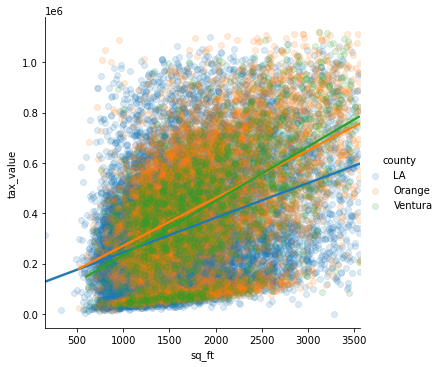

In [25]:
# This lmplot shows the plot of all homes' sq_ft by tax_value, with a hue on 'county'
sns.lmplot(x='sq_ft',y='tax_value',data=train, hue= 'county',scatter_kws={'alpha':.15})

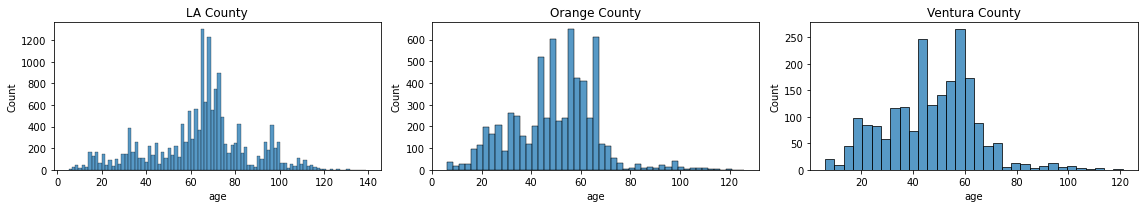

In [27]:
# This code can be accessed in my viz.py module, and creates histograms of age by county:
viz.age_by_county(train)

### Takeaway: LA county has slightly older homes that have kept their value more than homes in the other counties. Please note the left skew of Orange and Ventura counties (compared to LA)

## Research question 4: Do more bathrooms relate to higher tax value? What about square feet per bathroom--is there a sweet spot?

<AxesSubplot:xlabel='bathrooms', ylabel='tax_value'>

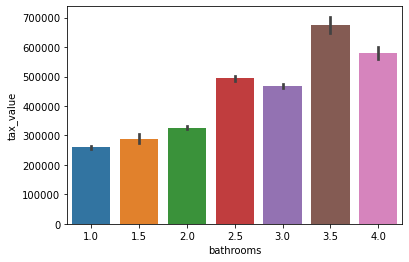

In [28]:
# A seaborn barplot of bathrooms vs. tax value
sns.barplot(x=train.bathrooms, y=train.tax_value)

### It's clear that more bathrooms correlate with higher tax value (see also the heatmap above).  

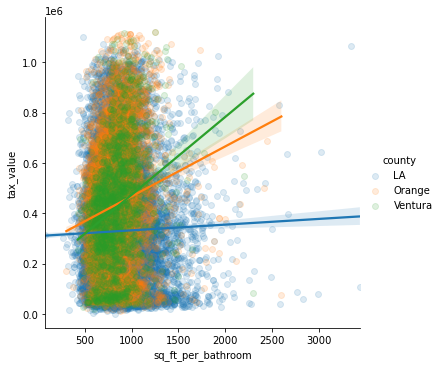

In [29]:
# A seaborn lmplot of sq_ft against tax_value, by county
sns.lmplot(x='sq_ft_per_bathroom',y='tax_value',data=train, hue= 'county',scatter_kws={'alpha':.15})

## Takeaway: sfpb has less impact on tax value in LA county than in the other two counties.  This is evidence that two models could be handy (LA county vs. the other two)

## I'm also of the opinion that having a half bath might be correlated to higher tax value as well, which would be a feature to pursue for further research

### I am conducting a pearson-r below to back up my theory stated in the above cell; the assumptions of the test are met.

In [30]:
# Boolean mask creating samples for LA county and the other two counties:
LA_sample = train[train.county == 'LA']
Other_counties_sample = train[train.county != 'LA']

### Differing variances

Set Hypothesis
- 𝐻0 : In LA county, sfpb does not impact tax value
- 𝐻𝑎 : In LA county, sfpb does impact tax value

In [31]:
# A pearson-r test for the Los Angles sample, sq_ft as it corrletes to tax value
corr_LA, p = stats.pearsonr(LA_sample.sq_ft_per_bathroom,LA_sample.tax_value)
corr_LA, p

(0.024920318962505083, 0.0014043736499767124)

In [32]:
# The same as above, but for Ventura and Orange counties
corr_Others, p = stats.pearsonr(Other_counties_sample.sq_ft_per_bathroom,Other_counties_sample.tax_value)
corr_Others, p

(0.1738096142789595, 5.566970219475142e-60)

### Takeaway: there is a somewhat stronger correlation between sfpb in Other counties than in LA, almost seven times as much in fact

# Summary: Exploration
- I have been able to produce a tidy list of variables that are demonstrated to have an impact on tax value, including:
    - square feet
    - number of bathrooms
  
- Apart from this, there is evidence that these relationships work somewhat differently from county to county; for this reason, a furthur exploration will likely include models for LA county versus the rest

- For now, my modeling will be based on the results of the K-Best and RFE feature functions in the following cell; both include square feet as one of the top features, and the K-Best model also includes number of bathrooms.

# Feature engineering
- I have used the scaled data set to arrive at my kbest and rfe features

In [33]:
# This cell runs my function in feature_engineering.py that selects for the top 'k' number 
# of features
import feature_engineering
f_feature = feature_engineering.select_kbest(X_train_scaled,y_train, 3)
f_feature

['bathrooms', 'sq_ft', 'age']

In [34]:
# Likewise, here we are using a function from the feature_engineering.py file to select for the best RFE features

rfe_feature = feature_engineering.select_rfe(X_train_scaled,y_train, 3)
rfe_feature

['sq_ft', 'LA', 'Orange']

# Modeling
- I have done modeling on the scaled datasets

### Baseline

- I will use MEAN as the baseline

### Features

I will use ['bathrooms', 'sq_ft', 'age'] as my kbest features; ['sq_ft', 'LA', 'Orange'] as my rfe features


### All the X_train_scaled, X_validate_scaled, etc. are scaled from X_train, etc.
### All of the X_train_kbest, X_train_rfe, etc are derived from the scaled datasets

In [35]:
# This cell is running a function in my model.py file
# It creates data sets for modeling based on the KBest and RFE features, respectively:
X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe \
= model.create_data_for_models(X_train_scaled, X_validate_scaled, X_test_scaled)

In [36]:
# 1. Predict tax_value_pred_mean
# I create here new columns in the y_ data sets too hold the baseline value I am working with.
tax_value_pred_mean = y_train_scaled.tax_value.mean()
y_train_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean, 2)
y_validate_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean,2)
y_test_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean,2)

In [37]:
# 2. RMSE of tax_value_pred_mean
# Here, I calculate the Root Mean Squared Error of the baseline and print it
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train_scaled.tax_value,
                                y_train_scaled.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.21 
Validate/Out-of-Sample:  0.21


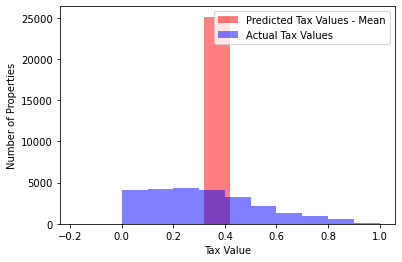

In [38]:
# This cell draws up a chart of all tax values as compared to the baseline using my viz.py module
viz.actual_vs_predicted(y_train_scaled)

In [39]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898


In [40]:
# This function runs all the KBest and RFE models respectively on all the different models I've built
# I'm saving the output to the metric_df dataframe for visualization
metric_df = model.run_all_models_on_all_data(X_train_kbest, y_train_scaled, X_validate_kbest, y_validate_scaled, X_train_rfe, X_validate_rfe, X_test_kbest, X_test_rfe, metric_df)

In [41]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor RFE,0.186380,0.185511
2,OLS Regressor KBEST,0.187970,0.187550
3,Lasso_alpha1_KBEST,0.208851,0.208888
4,Lasso_alpha1_RFE,0.208851,0.208888
5,glm_compound_kbest,0.187992,0.187311
6,glm_compound_rfe,0.186132,0.185047
7,quadratic_kbest,0.187065,0.186616
8,quadratic_rfe,0.185730,0.184879


## As can be seen in the table above, the model that is producing the best outcome, both on train and validate, with relatively little difference between them, is the polynomial model.

## The number of degrees used was 2

## Model Evaluation

In [42]:
# Make the polynomial features to get a new set of features. import from sklearn
pf = PolynomialFeatures(degree=2)

# Fit and transform X_train_scaled
X_train_degree2_rfe = pf.fit_transform(X_train_rfe)

# Transform X_validate_scaled & X_test_scaled
X_validate_degree2_rfe = pf.transform(X_validate_rfe)
X_test_degree2_rfe =  pf.transform(X_test_rfe)

In [43]:
# I use the RFE features here:
# Create the model object
lm2 = LinearRegression()

# Fit the model to our test data. 
lm2.fit(X_test_degree2_rfe, y_test_scaled.tax_value)

# Create a column in the y_test_scaled dataframe to hold the polynomial regression prediction:
y_test_scaled['tax_value_pred_lm2_rfe'] = lm2.predict(X_test_degree2_rfe)

# Evaluate by calculating its RMSE on test
rmse_test = mean_squared_error(y_test_scaled.tax_value, y_test_scaled.tax_value_pred_lm2_rfe) ** (1/2)
# A statement reminding us of the RMSE on the train and validate samples:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", metric_df.RMSE_train.iloc[8], 
      "\nValidation/Out-of-Sample: ", metric_df.RMSE_validate.iloc[8],)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.18573040401903843 
Validation/Out-of-Sample:  0.18487887876821385


In [44]:
# And a statement on the RMSE of the second degree polynomial model
print("RMSE for Polynomial Model, degrees=2\nTest/Out of Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test/Out of Sample:  0.18402719726701586


In [45]:
# This is a simple calculation of the improvement over baseline:
(0.208898 - 0.184027) / 0.208898

0.11905810491244533

## WHICH IS TO SAY, AN 11.9% IMPROVEMENT OVER BASELINE PREDICTION

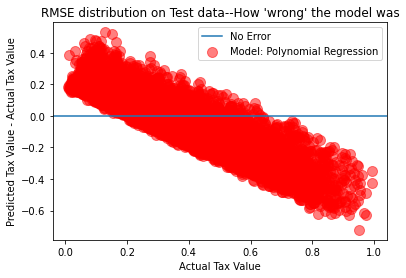

In [52]:
# A matplotlib scatterplot showing the residual error between predicted RMSE and actual tax value

plt.axhline(label="No Error")
plt.scatter(y_test_scaled.tax_value, y_test_scaled.tax_value_pred_lm2_rfe - y_test_scaled.tax_value,\
            alpha=.5, color="red", s=100, label="Model: Polynomial Regression")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value - Actual Tax Value")
plt.title("RMSE distribution on Test data--How 'wrong' the model was")
plt.show()

### The graphic show how much of a difference there was between the predicted tax value and the actual; the model gave the best results in the middle

## Conclusions

## Summary:

At the beginning of my study, I took a few high-level type questions to get a handle on the problem, and refined them slowly with the time that was available:
   
    - Are larger homes valued higher?  
    - What other aspects can be identified about higher-value homes?
    - Do more bathrooms relate to higher tax value? What about square feet per bathroom--is there a sweet spot?
    - Newer homes are larger; they are also valued more highly. Is there an exception to the rule?
    
Many of these questions had clear answers, but through statistical analysis I was able to make safe assumptions, which in turn led me down paths that I may have otherwise missed. More square feet, bedrooms and bathrooms all correlate to higher tax value; who would have thought that the relationship between these factors works differently depending on your county? 

Even my model, which has room for improvement, was capable of predicting the tax value of homes--by over 10 percent on the test data, and with similar margins for the train and validate data. I expect it to perform as well on unseen data as well--keeping certain parameters constant.

## Recommendations

I recommend exploring the relationship between half bathrooms and tax value as an easy addition to the model that may bring some benefit.  Additionally, running the model on LA county as separate from Ventura and orange might see some benefit, seeing as there area some different ways that the features work on tax value there. Square feet per bathroom is an example here--it didn't make it into my model, but may have value for future models.  

## Next steps

Continuing to select new features from the Codeup database stands to improve the model--assuming they don't present unforeseen problems such as numerous null values, etc.  Fireplaces and pools and certain feature engineering around those elements in particular could be interesting (is it detrimental to have too many? for example). Even from my most preliminary analysis, it seemed that half baths were beneficial, and it would be interesting to look at similar phenomena in those other featurs mentioned (and unmentioned).  I would also like to explore the method I've used to eliminate outliers, at least for some features--I'm worried that there might have been some useful info that was dropped with the outliers, especially one bedroom homes.

The following is a brief list of items that I'd like to add to the model:

- Incorporate a "has half bath" feature
- Run models on other features, including the half-bath and sfpb
- Run models on LA versus other counties
- Pull in other features from SQL
- Ordinal encode the bathrooms and bedrooms